In [1]:
%cd ../..
%pip install -e .

/home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
Obtaining file:///home/sandor/dtu/2021-22-spring/advanced_machine_learning/p-reg
  Preparing metadata (setup.py) ... done
  Attempting uninstall: src
    Found existing installation: src 0.1.0
    Uninstalling src-0.1.0:
      Successfully uninstalled src-0.1.0
  Running setup.py develop for src
Note: you may need to restart the kernel to use updated packages.


In [2]:
from utils import train
from utils import test
from models import MLP, GCN, GAT
from random_split import random_split
from p_reg_loss import A_hat_computations
# from p_reg_loss import p_reg_loss
from lap_loss import lap_loss
from helper import visualize_Atlas, visualize_TSNE, visualize_CM, print_dataset, print_data
from src.models.evaluate_model import evaluate1abdul

# packages
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
import numpy as np 
import time
import matplotlib.pyplot as plt
import pandas as pd
import random


In [3]:
# set up torch env and dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root=f'data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to(device)

In [4]:
# hyperparams

epochs = 200
seed = 0
reg_loss = 'p_reg'
train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
A_hat, A_hat_mask, N = A_hat_computations(data)


In [5]:
print(A_hat_mask.sum())

tensor(2708)


In [6]:
def p_reg_loss(Z, A_hat,  A_hat_mask, N):
    """
    See section 2 from 
    Rethinking Graph Regularization for Graph Neural Networks
    """
    Z = Z[ A_hat_mask, :]
    Z_prime = torch.matmul(A_hat, Z)

    # have a look at the table before eq (2) and appendix A
    P = torch.softmax(Z, dim=1)
    Q = torch.softmax(Z_prime, dim=1)
    phi = - (P * torch.log(Q)).sum()

    return (1/N) * phi


In [7]:
metrics = []

for mu in range(11):
    torch.manual_seed(seed)
    random.seed(seed)
    
    mu = mu / 10




    model = GCN(dataset, hidden_channels=16, seed = seed).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        _, Z = model(data)

        loss_1 = criterion(Z[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
        loss_2 = p_reg_loss(Z, A_hat, A_hat_mask, N)
        loss = loss_1 + mu * loss_2

        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

    train_acc, val_acc, test_acc = evaluate1abdul(model, data)
    metrics.append({'mu': mu, 'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc})
    print(metrics[-1])


{'mu': 0.0, 'train_acc': 0.9928571428571429, 'val_acc': 0.794, 'test_acc': 0.803}
{'mu': 0.1, 'train_acc': 0.9928571428571429, 'val_acc': 0.792, 'test_acc': 0.81}
{'mu': 0.2, 'train_acc': 0.9928571428571429, 'val_acc': 0.792, 'test_acc': 0.819}
{'mu': 0.3, 'train_acc': 0.9928571428571429, 'val_acc': 0.792, 'test_acc': 0.83}
{'mu': 0.4, 'train_acc': 0.9857142857142858, 'val_acc': 0.792, 'test_acc': 0.835}
{'mu': 0.5, 'train_acc': 0.9857142857142858, 'val_acc': 0.768, 'test_acc': 0.812}
{'mu': 0.6, 'train_acc': 0.9857142857142858, 'val_acc': 0.768, 'test_acc': 0.789}
{'mu': 0.7, 'train_acc': 0.9857142857142858, 'val_acc': 0.754, 'test_acc': 0.766}
{'mu': 0.8, 'train_acc': 0.9785714285714285, 'val_acc': 0.728, 'test_acc': 0.735}
{'mu': 0.9, 'train_acc': 0.9571428571428572, 'val_acc': 0.64, 'test_acc': 0.646}
{'mu': 1.0, 'train_acc': 0.8571428571428571, 'val_acc': 0.4, 'test_acc': 0.388}


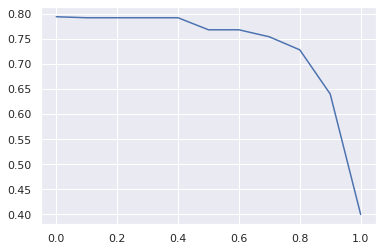

In [8]:
df = pd.DataFrame(metrics)
plt.plot(df['mu'], df['val_acc'])
plt.show()